In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import corner
import pandas as pd
from lsst.sims.photUtils.SignalToNoise import *
from lsst.sims.photUtils.PhotometricParameters import PhotometricParameters
from lsst.sims.photUtils.BandpassDict import BandpassDict
%matplotlib inline

In [2]:
means = np.load("means.npy").reshape(20, -1, 8)
logvar = np.load("logvar.npy").reshape(20, -1, 8)
X = pd.read_csv("processed_X.csv")
Y = pd.read_csv("processed_y.csv").values

In [3]:
column_names = pd.read_csv("processed_y.csv").columns.values
column_dict = dict(zip(np.arange(8), column_names))

In [4]:
X_val = X.loc[10262:, ].reset_index(drop=True)
Y_val = Y[10262:, ]
Y_val.shape

(2566, 8)

In [ ]:
column_dict

In [ ]:
X_val.loc[:, list('ugrizy')].head()

In [5]:
chosen = np.random.choice(Y_val.shape[0], size=100, replace=False)
X_val_sampled = X_val.loc[chosen, :]
Y_val_sampled = Y_val[chosen, :]
means_sampled = means[:, chosen, :]
logvar_sampled = logvar[:, chosen, :]

In [8]:
def get_astrometric_err(mag, n_visits=184):
    """
    Calculate the astrometric error
    Returns astrometric error in mas.
    """
    m5 = 24.35 # r-band, per-visit
    return calcAstrometricError(mag, m5, nvisit=n_visits)

In [9]:
def get_mag_err(mag, band, gamma=None):
    """
    Calculate the magnitude error
    Returns magnitude error in mag.
    """
    LSST_BandPass = BandpassDict.loadTotalBandpassesFromFiles()
    bandpass_obj = LSST_BandPass[band]
    phot_params_obj = PhotometricParameters()
    #m5_visit = dict(zip(list('ugrizy'), [23,78, 24.81, 24.35, 23.92, 23.34, 22.45]))
    m5_coadd = dict(zip(list('ugrizy'), [26.1, 27.4, 27.5, 26.8, 26.1, 24.9]))
    mag_err, gamma = calcMagError_m5(mag, bandpass_obj, m5_coadd[band], phot_params_obj, gamma)
    return mag_err

### Marginal HPD intervals

In [10]:
def plot_marginal_mapping(Y_val, means, logvar):
    n_params = Y_val.shape[1]
    fig, axs = plt.subplots(n_params//2, 2, figsize=(6*2, 4*(n_params//2)), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for param in range(n_params):
        mean_avg = np.mean(means, axis=0)[:, param]
        epistemic_var = np.var(means, axis=0).mean(axis=0)[param]
        aleatoric_var = np.mean(np.exp(logvar), axis=0)[:, param]
        total_var = aleatoric_var + epistemic_var
        display_var = aleatoric_var
        display_sig = display_var**0.5
        truth = Y_val_sampled[:, param]
        axs[param].errorbar(truth, mean_avg, marker='.', linewidth=0, yerr=display_sig, elinewidth=0.5, label=r'1-$\sigma$ aleatoric')
        perfect = np.linspace(np.min(truth), np.max(truth))
        axs[param].plot(perfect, perfect, linestyle='--', color='r', label="Perfect mapping")
        if column_dict[param] in ['ra', 'dec']:
            r_mag = X_val_sampled.loc[:, 'r'].values
            obs_err = get_astrometric_err(r_mag)/1000.0
            sys_type = 'astrometric'
        else: # magnitude columns
            band = column_dict[param].split('_')[1] # FIXME: hacky
            mag = X_val_sampled.loc[:, band].values
            obs_err = get_mag_err(mag, band)/1000.0
            sys_type = 'photometric'
        sorted_id = np.argsort(truth)
        sorted_truth = truth[sorted_id]
        axs[param].fill_between(sorted_truth, sorted_truth-obs_err[sorted_id], sorted_truth + obs_err[sorted_id], alpha=0.5, facecolor='tab:orange', label=r'1-$\sigma$ %s' %sys_type)
        axs[param].set_title(column_dict[param])
        axs[param].set_ylabel("Emulated")
        axs[param].set_xlabel("Observed")
        axs[param].plot([], [], ' ', label=r"Avg 1-$\sigma$ total: %.2f" %np.mean((total_var)**0.5))
        axs[param].plot([], [], ' ', label=r"Avg 1-$\sigma$ epistemic: %.2f" %np.mean((epistemic_var)**0.5))
        axs[param].plot([], [], ' ', label=r"Avg 1-$\sigma$ aleatoric: %.2f" %np.mean((aleatoric_var)**0.5))
        axs[param].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.subplots_adjust(wspace=1.0, hspace=0.5)
    #plt.tight_layout()

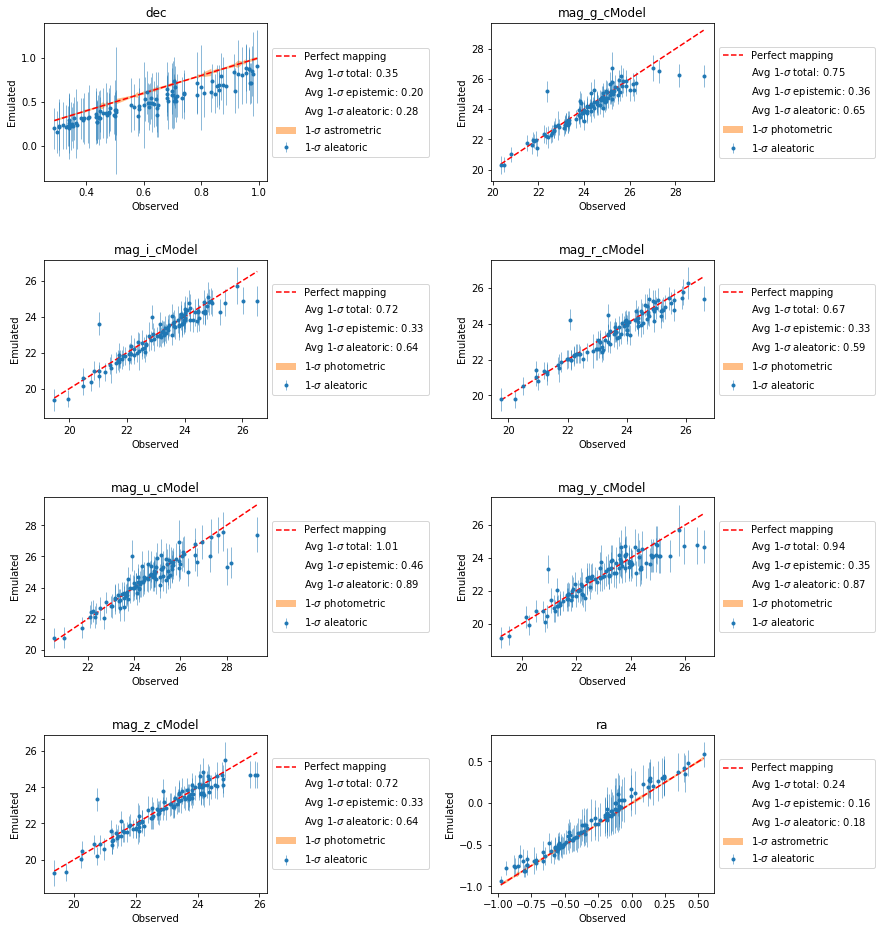

In [11]:
plot_marginal_mapping(Y_val_sampled, means_sampled, logvar_sampled)

### Marginal offset evaluation

In [12]:
def plot_marginal_offset(Y_val, means, logvar):
    n_params = Y_val.shape[1]
    fig, axs = plt.subplots(n_params//2, 2, figsize=(6*2, 4*(n_params//2)), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for param in range(n_params):
        mean_avg = np.mean(means, axis=0)[:, param]
        epistemic_var = np.var(means, axis=0).mean(axis=0)[param]
        aleatoric_var = np.mean(np.exp(logvar), axis=0)[:, param]
        total_var = aleatoric_var + epistemic_var
        display_var = 2.0*aleatoric_var # two sources of aleatoric uncertainty in the offset
        display_sig = 1000.0*display_var**0.5 # in milliunits
        truth = Y_val_sampled[:, param]
        offset = (mean_avg - truth)*1000.0 # mas or mmag
        if column_dict[param] in ['ra', 'dec']:
            r_mag = X_val_sampled.loc[:, 'r'].values
            obs_err = get_astrometric_err(r_mag)*np.sqrt(2)
            sys_type = 'astrometric'
        else: # magnitude columns
            band = column_dict[param].split('_')[1] # FIXME: hacky
            mag = X_val_sampled.loc[:, band].values
            obs_err = get_mag_err(mag, band)*1000.0*np.sqrt(2) # in mmag
            sys_type = 'photometric'
        sorted_id = np.argsort(truth)
        axs[param].fill_between(truth[sorted_id], -obs_err[sorted_id], obs_err[sorted_id], alpha=0.5, facecolor='tab:orange', label=r'1-$\sigma$ %s' %sys_type)
        axs[param].errorbar(truth, offset, marker='.', linewidth=0, yerr=display_sig, elinewidth=0.5, label=r'1-$\sigma$ aleatoric')
        perfect = np.linspace(np.min(truth), np.max(truth))
        axs[param].plot(perfect, np.zeros_like(perfect), linestyle='--', color='r', label="Perfect mapping")
        axs[param].set_title(column_dict[param])
        axs[param].set_ylabel("Emulated - Observed")
        axs[param].set_xlabel("Observed")
        axs[param].plot([], [], ' ', label=r"Avg 1-$\sigma$ total: %.2f" %np.mean((2.0*total_var)**0.5))
        axs[param].plot([], [], ' ', label=r"Avg 1-$\sigma$ epistemic: %.2f" %np.mean((2.0*epistemic_var)**0.5))
        axs[param].plot([], [], ' ', label=r"Avg 1-$\sigma$ aleatoric: %.2f" %np.mean((2.0*aleatoric_var)**0.5))
        axs[param].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.subplots_adjust(wspace=1.0, hspace=0.5)
    #plt.tight_layout()

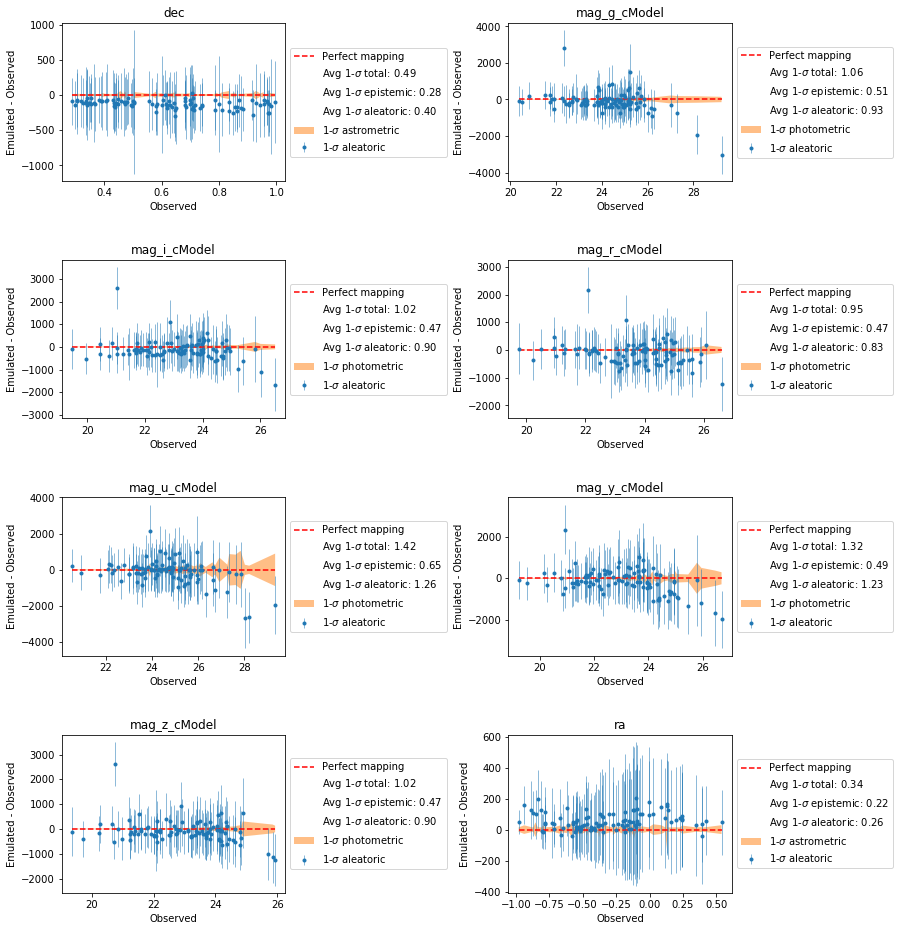

In [13]:
plot_marginal_offset(Y_val_sampled, means_sampled, logvar_sampled)

### Full posterior cornerplot

In [17]:
list(column_dict.values())

['dec',
 'mag_g_cModel',
 'mag_i_cModel',
 'mag_r_cModel',
 'mag_u_cModel',
 'mag_y_cModel',
 'mag_z_cModel',
 'ra']

In [21]:
def draw_cornerplot(pred, fig=None, color='black'):
    n_samples, n_data, n_params = means_sampled.shape
    plot = corner.corner(pred, 
                        color=color, 
                        smooth=1.0, 
                        labels=list(column_dict.values()),
                        #show_titles=True,
                        fill_contours=True,
                        bins=50,
                        fig=fig,
                        range=[0.999]*n_params,
                        hist_kwargs=dict(normed=True, ))
    return plot

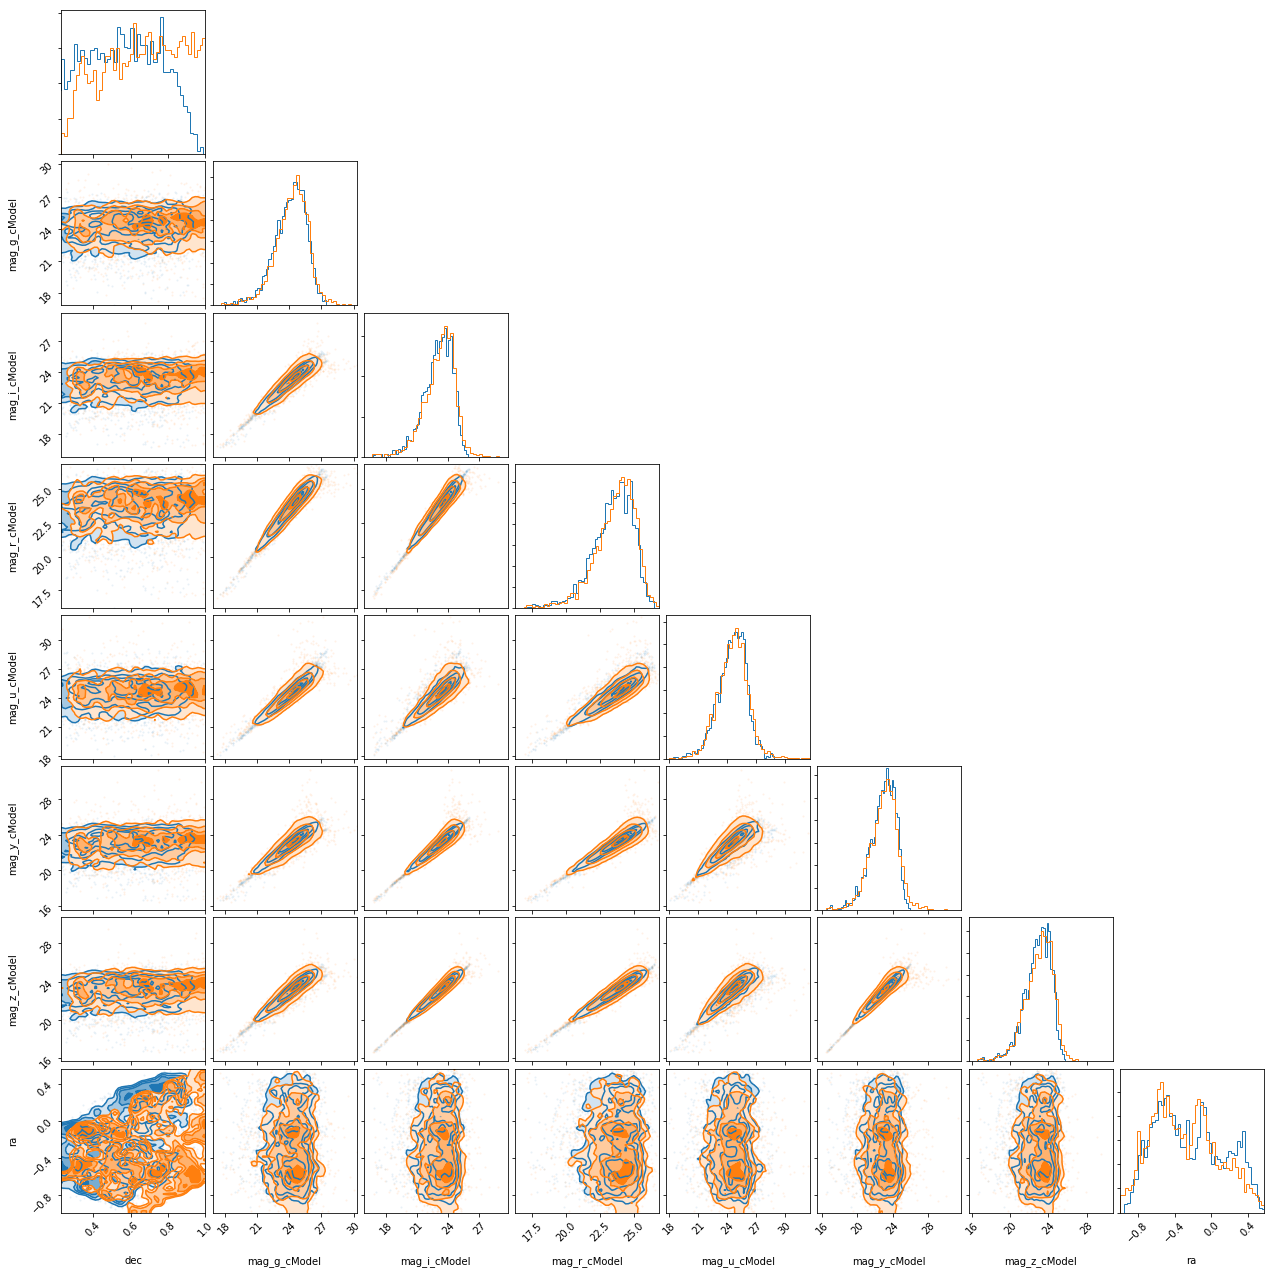

In [23]:
pred = np.mean(means, axis=0)
pairwise_post_pred = draw_cornerplot(pred, color='tab:blue')
pairwise_post_observed = draw_cornerplot(Y_val, fig=pairwise_post_pred, color='tab:orange')